Seyed Mahdi Kashani Sani <br/>
99222081

In [1]:
import random
from math import sin, exp
from typing import Callable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Current

In [2]:
class Current:
    def __init__(self, method: Callable[[float], float]):
        """
            Parameters
            ----------
                method: Callable[[float], float]
                    the callback function that you want set for generator current
        """
        self.method = method
    
    def getCurrent(self, t: float)->float:
        return self.method(t)

    def plot_I_t(self, times: np.ndarray, size_plot=(9, 5), color=u"#f0f",
            save_file=False, filename="I-t plot.png", dpi=500):
        plt.figure(figsize=size_plot)
        plt.plot(times, list(map(self.getCurrent, times)),
                color= color, linestyle='-', label='Current')

        plt.legend()
        plt.grid()
        plt.title('Current')
        plt.ylabel('Current (mA)')
        plt.xlabel('Time (msec)')
        if save_file:
            plt.savefig(filename, dpi=dpi, bbox_inches='tight', pad_inches=0.1)
        else:
            plt.show();

class DirectCurrent(Current):
    def __init__(self, a_0=5.):
        super().__init__(lambda t : a_0)

class AlternativeCurrent(Current):
    def __init__(self, a_0=0., a_1=1., a_2=1.):
        super().__init__(lambda t : a_1 * (sin(t) + a_0) + a_2)

class RandomCurrent(Current):
    def __init__(self, begin_range=0., end_range=10., seed=0):
        super().__init__(lambda t : random.uniform(begin_range, end_range))
        random.seed(seed)

class LinearCurrent(Current):
    def __init__(self, a_0=0, a_1=1.):
        super().__init__(lambda t : a_0 + a_1 * t)

## Base Class

In [3]:
class Neuron:
    def __init__(self, time_total = 100, dt = 0.03125,
                R_m = 10, Tau_m = 8, V_start = -80, V_treshold = -45,
                V_spike = 5, V_rest = -79, V_reset = -65):

        self.time_total = time_total
        self.dt = dt
        self.times = np.arange(0, self.time_total, self.dt, dtype=float)
        self.R_m = R_m
        self.Tau_m = Tau_m
        self.V_start = V_start
        self.V_treshold = V_treshold
        self.V_spike = V_spike
        self.V_rest = V_rest
        self.V_reset = V_reset
        self.n_fire = 0
        self.V_m = []
        self.spikes = []

    def sim(self, I_t: Current):
        """
            simulate neuron with specified input current
            
            Parameters
            ----------
                I_t: Current
                    a object of class or subclass Current for set input neorun in simulate mode
        """
        raise Exception("Not implemented in base class!")

    def calculate_delta_v(self) -> float:
        return self.last_V - self.V_rest

    def calculate_dv(self, I_in_t: float, additional_sum: float = 0) -> float:
        """
            Parameter
            ---------
            I_in_t: float 
                current value at this time
            additional_sum: float
                if neuron adaptive or exponential, you could pass the values for add to formula

            Return
            ------
            Calculated value
        """
        dv = -1. * self.calculate_delta_v() + (self.R_m * I_in_t)
        dv += additional_sum
        dv /= self.Tau_m
        return self.dt * dv

    def check_threshold(self, time):
        """
            check this neuron has been spiked at this time. if true then try to reset neuron
        """
        if self.V_data[-1][0] >= self.V_treshold:
            self.V_data[-1] = (self.V_data[-1][0] + self.V_spike, time)
            self.V_data.append([self.V_reset, time])
            self.n_fire += 1
            self.spikes.append(time)

    def plot_voltage_time(self, size_plot = (9, 5), color = u"#503C53",
                        save_file = False, filename = "V_t plot.png", dpi = 300):
        plt.figure(figsize=size_plot)
        plt.plot(self.itr_times , self.V_m, color = color, label='Voltage')
        plt.plot([0,self.time_total], [self.V_treshold, self.V_treshold],
            color=u"#f00", linestyle='--', label='Threshold Voltage')

        plt.legend()
        plt.grid()
        plt.title(f'{type(self).__name__} Model')
        plt.ylabel('Membrane Potential (mV)')
        plt.xlabel('Time (msec)')

        if save_file:
            plt.savefig(filename, dpi=dpi, bbox_inches='tight', pad_inches=0.1)
        else:
            plt.show()

    def plot_spikes(self):
        plt.figure(figsize=(9, 5))
        for spike in self.spikes:
            plt.axvline(x=spike)
        
        plt.title(f'spikes {type(self).__name__} Model')
        plt.xlabel('time (msec)')
        plt.ylabel('           ')
        plt.xlim(-5, self.time_total+5)
        plt.show()

    @classmethod
    def frequency_current_plot(cls, time = (0, 100), step=10, size_plot = (9, 5),
                            color=u"#503C53", save_file=False,
                            filename="F_t plot.png", dpi=300):
        frequencies = []
        for i in range(time[0], time[1], step):
            neuron = cls()
            neuron.sim(I_t=DirectCurrent(a_0=i/10.))
            frequencies.append(neuron.n_fire/neuron.time_total)
        
        plt.figure(figsize=size_plot)
        plt.grid()
        plt.title(f'{type(cls).__name__} Model')
        plt.ylabel('Frequency (KHz)')
        plt.xlabel('Input Current (pA)')
        plt.plot(np.arange(time[0], time[1], step)/10., frequencies, color=color)
        if save_file:
            plt.savefig(filename, dpi=dpi, bbox_inches='tight', pad_inches=0.1)
        else:
            plt.show()
    
    @property
    def last_V(self): return self.V_data[-1][0]

    def __str__(self):
        return (
            f"time_total = {self.time_total}"
            f"\ndt = {self.dt}"
            f"\nR_m = {self.R_m}"
            f"\nTau_m = {self.Tau_m}"
            f"\nV_start = {self.V_start}"
            f"\nV_treshold = {self.V_treshold}"
            f"\nV_spike = {self.V_spike}"
            f"\nV_rest = {self.V_rest}"
            f"\nV_reset = {self.V_reset}"
            f"\nn_fire = {self.n_fire}"
        )

## LIF

### Implementation

In [4]:
class LIF(Neuron):
    def __init__(self, time_total=100, dt=0.03125,
                R_m=10, Tau_m=8, V_start = -80,
                V_treshold=-45, V_spike=5, V_rest=-79, V_reset=-65):

        super().__init__(time_total, dt, R_m, Tau_m, V_start,
                        V_treshold, V_spike, V_rest, V_reset)

    def sim(self, I_t: Current):
        self.spikes = []
        self.V_data = [(self.V_start, 0)] # save the voltage values
        pass_time = 0

        while pass_time <= self.time_total:
            dv = self.calculate_dv(I_t.getCurrent(pass_time))
            self.V_data.append([self.last_V + dv, pass_time])

            self.check_threshold(pass_time)

            pass_time += self.dt

        v_data = np.array(self.V_data)
        self.itr_times = v_data[:,1]
        self.V_m = v_data[:,0]

### Examples LIF model

In [5]:
# function for test each current sample
def test(neuron, I):
    neuron.sim(I_t=I)
    neuron.plot_voltage_time()
    neuron.plot_spikes()
    print(neuron.__str__())

#### sample 1

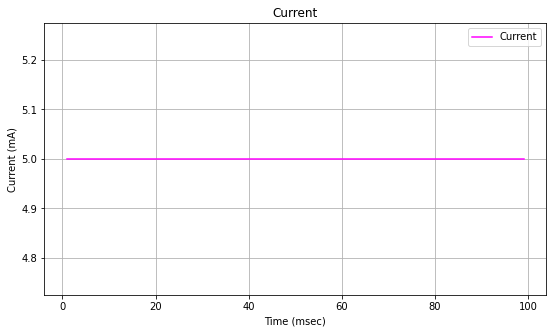

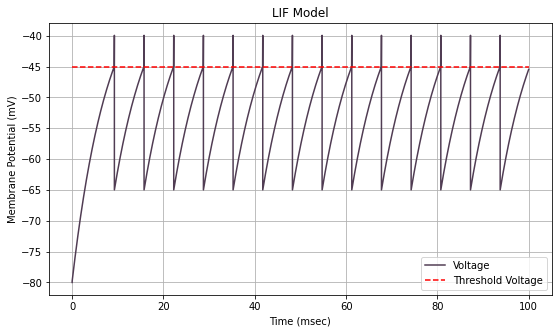

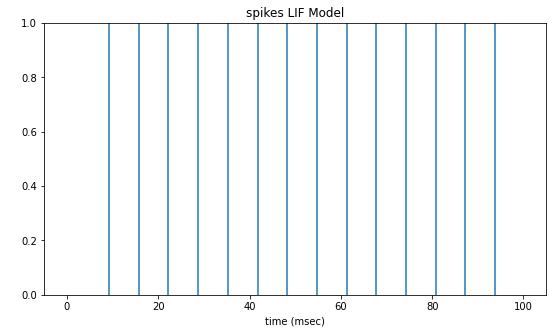

time_total = 100
dt = 0.03125
R_m = 10
Tau_m = 8
V_start = -80
V_treshold = -45
V_spike = 5
V_rest = -79
V_reset = -65
n_fire = 14


In [6]:
neuron = LIF()
I = DirectCurrent() # I = 5
I.plot_I_t(np.arange(1,100))
test(neuron, I)

### sample 2

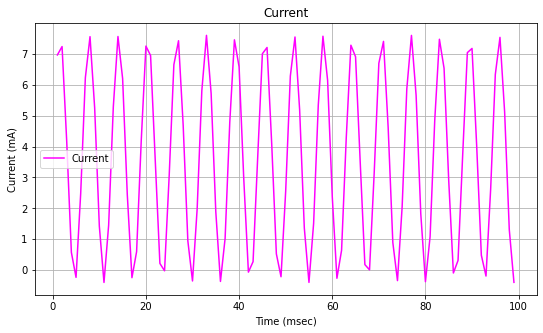

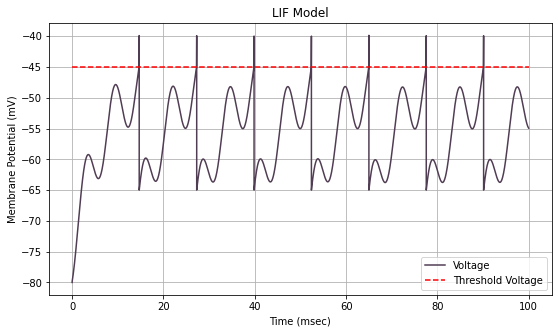

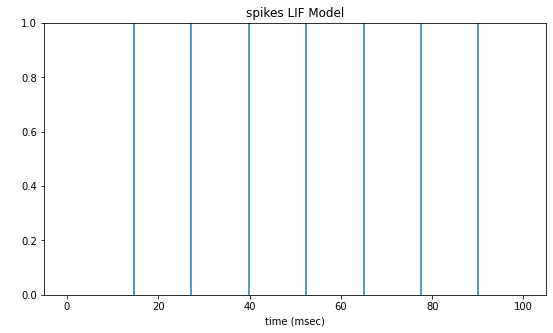

time_total = 100
dt = 0.03125
R_m = 10
Tau_m = 8
V_start = -80
V_treshold = -45
V_spike = 5
V_rest = -79
V_reset = -65
n_fire = 7


In [7]:
neuron = LIF()
I = AlternativeCurrent(a_0=0.9, a_1=4,a_2=0) # I(t) = (0.9 + sin(t)) * 4
I.plot_I_t(np.arange(1,100))
test(neuron, I)

### sample 3

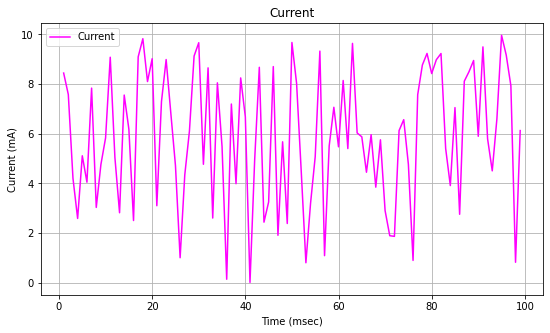

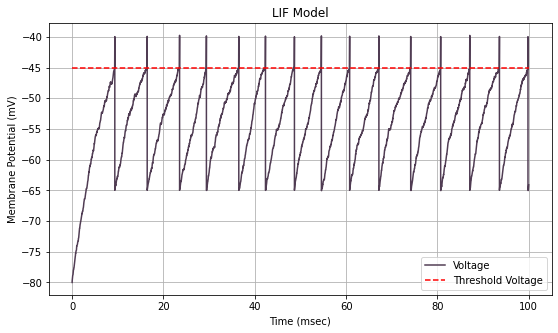

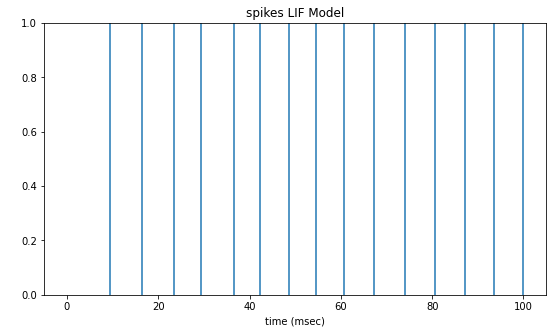

time_total = 100
dt = 0.03125
R_m = 10
Tau_m = 8
V_start = -80
V_treshold = -45
V_spike = 5
V_rest = -79
V_reset = -65
n_fire = 15


In [8]:
neuron = LIF()
I = RandomCurrent(begin_range=0, end_range=10)
I.plot_I_t(np.arange(1,100))
test(neuron, I)

### sample 4

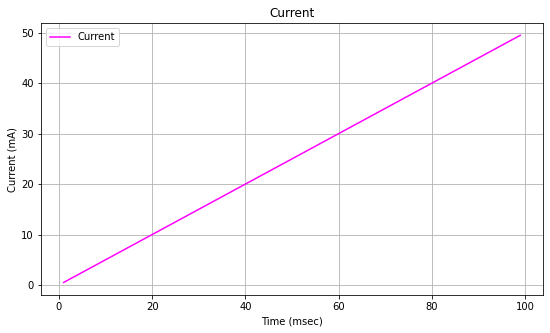

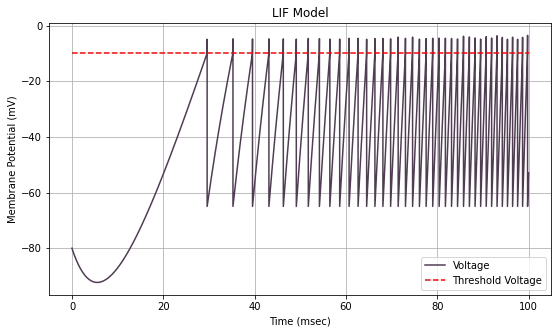

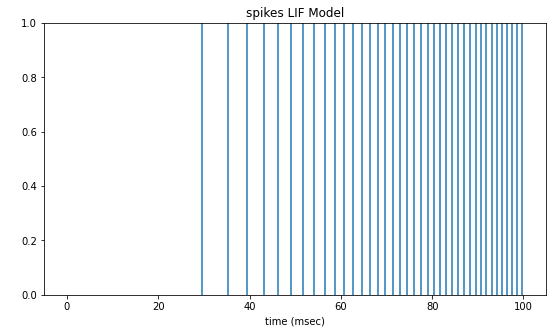

time_total = 100
dt = 0.03125
R_m = 10
Tau_m = 8
V_start = -80
V_treshold = -10
V_spike = 5
V_rest = -120
V_reset = -65
n_fire = 39


In [9]:
neuron = LIF(V_rest=-120, V_treshold=-10)
I = LinearCurrent(a_1=0.5) # I(t) = 0.5 * t
I.plot_I_t(np.arange(1,100))
test(neuron, I)

### sample 5

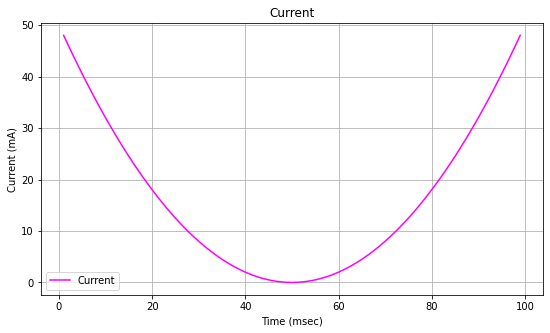

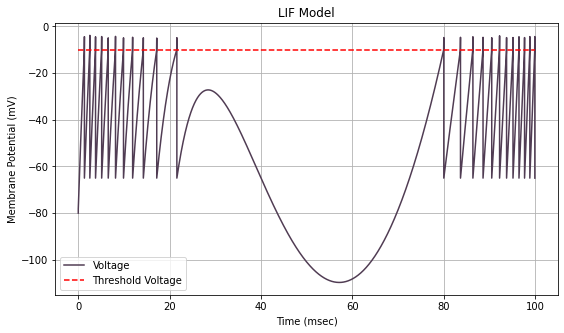

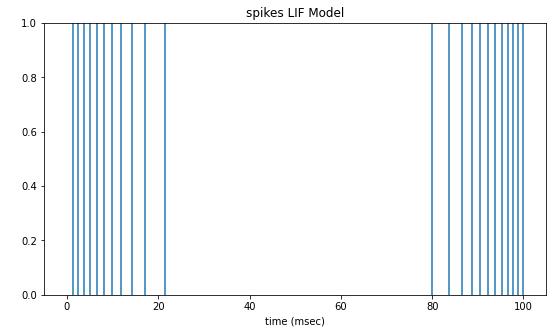

time_total = 100
dt = 0.03125
R_m = 10
Tau_m = 8
V_start = -80
V_treshold = -10
V_spike = 5
V_rest = -120
V_reset = -65
n_fire = 23


In [10]:
neuron = LIF(V_rest=-120, V_treshold=-10)
I = Current(lambda t : ((t - 50) ** 2.) / 50.) # I(t) = (t - 50) ^2
I.plot_I_t(np.arange(1,100))
test(neuron, I)

### sample 6

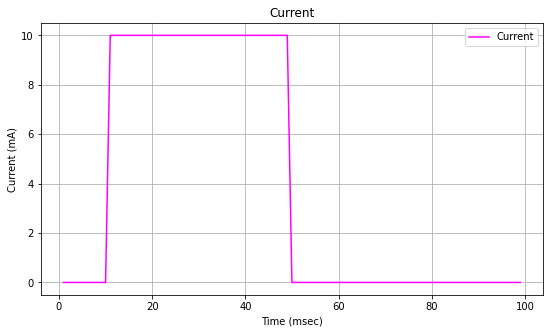

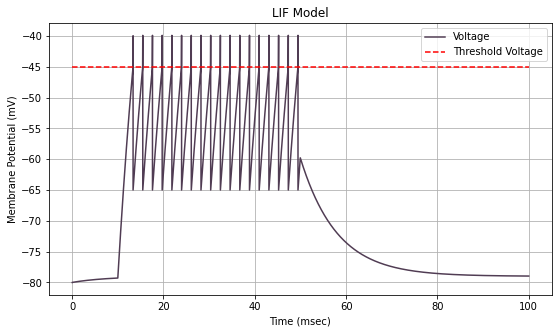

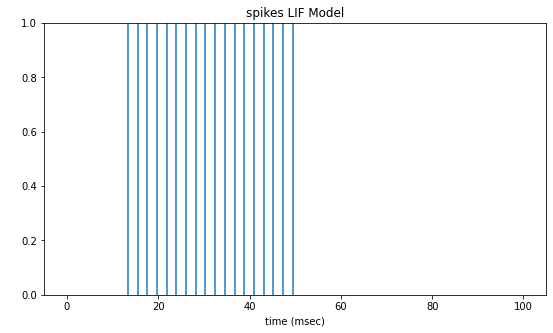

time_total = 100
dt = 0.03125
R_m = 10
Tau_m = 8
V_start = -80
V_treshold = -45
V_spike = 5
V_rest = -79
V_reset = -65
n_fire = 18


In [11]:
def I_function(t):
    return 10 if 10 < t < 50 else 0

neuron = LIF()
I = Current(I_function)
I.plot_I_t(np.arange(1,100))
test(neuron, I)

### Frequency plot

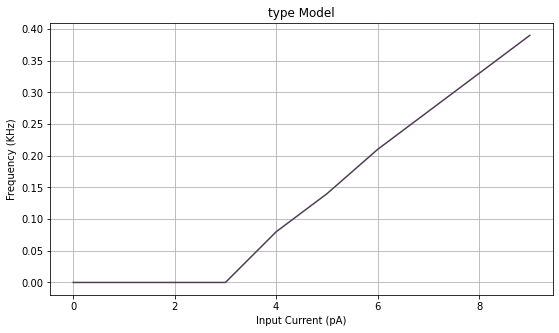

In [12]:
LIF.frequency_current_plot()

## ALIF

### Implementation

In [13]:
class ALIF(Neuron):
    def __init__(self, time_total=100, dt=0.03125,
                R_m=10, Tau_m=8, V_start=-80,
                V_treshold=-45, V_spike=5, V_rest=-79, 
                V_reset=-65, a=0.01, b=0.5, Tau_w=1):
        super().__init__(time_total, dt, R_m, Tau_m, V_start,
                        V_treshold, V_spike, V_rest, V_reset)
        self.a = a
        self.b = b
        self.Tau_w = Tau_w
        self.W_total = 0
        self.W_m = []

    def calculate_dw(self):
        dw = (self.calculate_delta_v() * self.a)
        dw -= self.W_total
        dw += self.n_fire * self.b
        dw /= self.Tau_w
        return dw * self.dt

    def update_w(self):
        self.W_total += self.calculate_dw()
        self.W_m.append(self.W_total)

    def sim(self, I_t: Current):
        self.V_data = [[self.V_start, 0]] # save the voltage values
        self.n_fire = 0
        pass_time = 0

        while pass_time <= self.time_total:
            self.update_w()
            dv = self.calculate_dv(I_t.getCurrent(pass_time), - self.W_total * self.R_m)
            self.V_data.append([self.last_V + dv, pass_time])

            self.check_threshold(pass_time)

            pass_time += self.dt

        self.last_I = I_t
        v_data = np.array(self.V_data)
        self.itr_times = v_data[:,1]
        self.V_m = v_data[:,0]

    def plot_w_time(self, size_plot = (9, 5), color = u"#00b853",
                        save_file = False, filename = "W_t plot.png", dpi = 300):
        plt.figure(figsize=size_plot)
        plt.plot(
            list(map(lambda i: i * self.dt, range(len(self.W_m)))),
            self.W_m, color=color, label='W'
        )

        plt.legend()
        plt.grid()
        plt.title(f'{type(self).__name__} Model')
        plt.ylabel('Adaptation Current (pA)')
        plt.xlabel('Time (msec)')

        if save_file:
            plt.savefig(filename, dpi=dpi, bbox_inches='tight', pad_inches=0.1)
        else:
            plt.show()

    def __str__(self)->str:
        return ( super().__str__() +
            f"\na = {self.a}"
            f"\nb = {self.b}"
            f"\nTau_w = {self.Tau_w}"
            f"\nW_total = {self.W_total}"
            )

### Examples ALIF Model

In [14]:
# test each current input
def test(neuron, I):
    neuron.sim(I_t=I)
    neuron.plot_voltage_time()
    neuron.plot_w_time()
    print(neuron.__str__())

#### sample 1

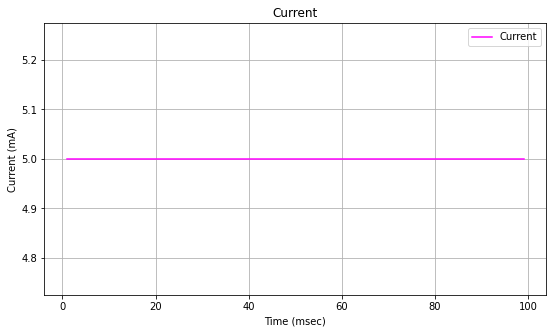

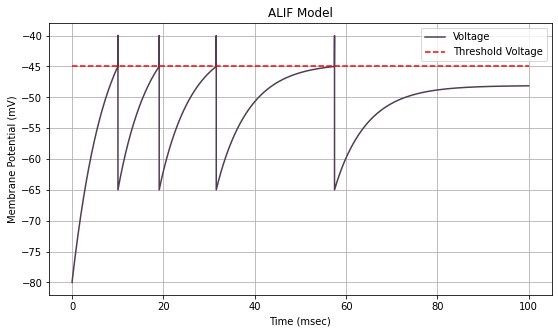

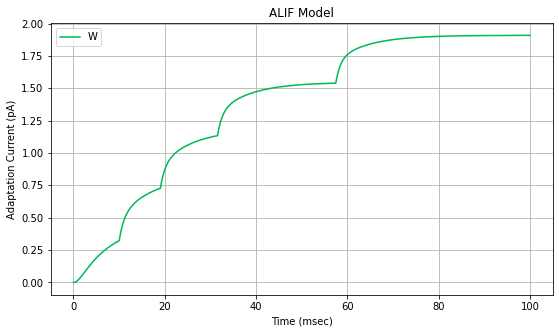

time_total = 100
dt = 0.03125
R_m = 10
Tau_m = 8
V_start = -80
V_treshold = -45
V_spike = 5
V_rest = -79
V_reset = -65
n_fire = 4
a = 0.01
b = 0.4
Tau_w = 1
W_total = 1.9085835957972093


In [15]:
neuron = ALIF(b=0.4)
I = DirectCurrent() # I = 5
I.plot_I_t(np.arange(1,100))
test(neuron, I)

#### sample 2

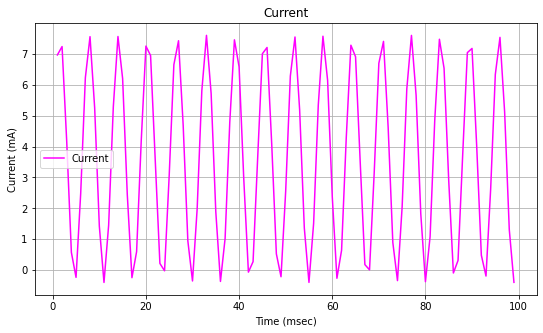

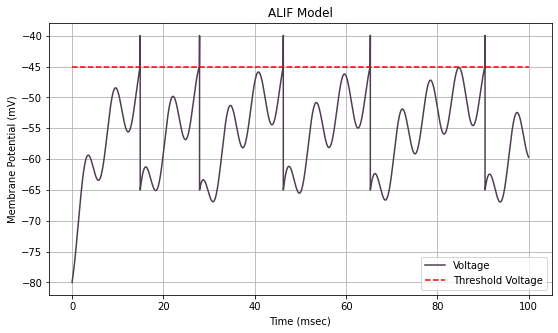

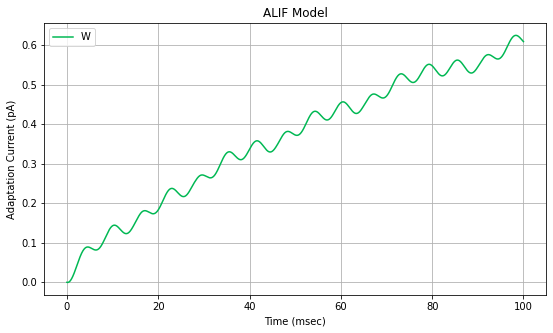

time_total = 100
dt = 0.03125
R_m = 10
Tau_m = 8
V_start = -80
V_treshold = -45
V_spike = 5
V_rest = -79
V_reset = -65
n_fire = 5
a = 0.005
b = 0.1
Tau_w = 1
W_total = 0.6086179867460113


In [16]:
neuron = ALIF(a=0.005, b=0.1)
I = AlternativeCurrent(a_0=0.9, a_1=4,a_2=0) # I(t) = (0.9 + sin(t)) * 4
I.plot_I_t(np.arange(1,100))
test(neuron, I)

#### sample 3

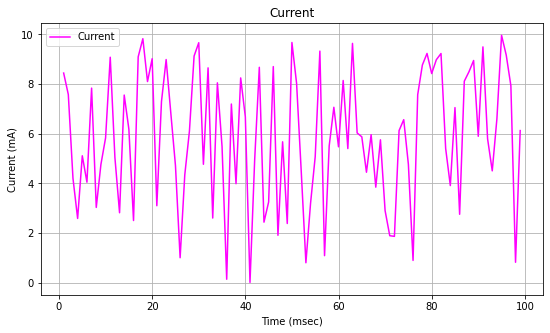

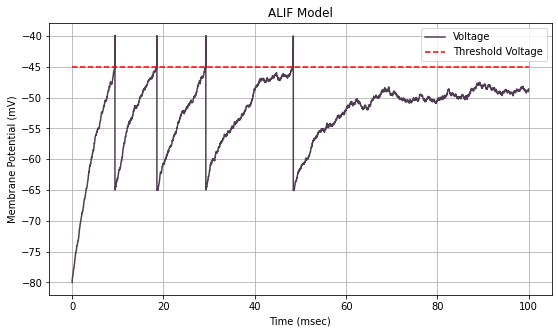

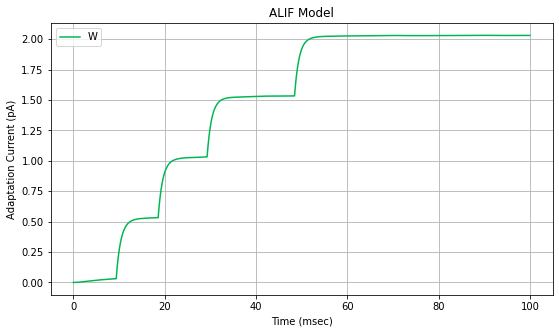

time_total = 100
dt = 0.03125
R_m = 10
Tau_m = 8
V_start = -80
V_treshold = -45
V_spike = 5
V_rest = -79
V_reset = -65
n_fire = 4
a = 0.001
b = 0.5
Tau_w = 1
W_total = 2.0301788424065346


In [17]:
neuron = ALIF(a=0.001)
I = RandomCurrent(begin_range=0, end_range=10)
I.plot_I_t(np.arange(1,100))
test(neuron, I)

#### sample 4

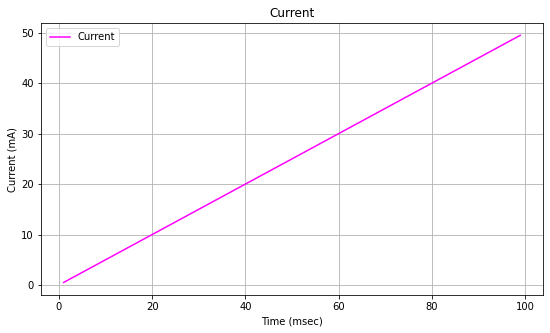

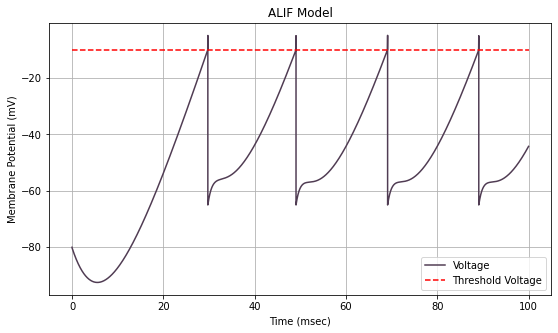

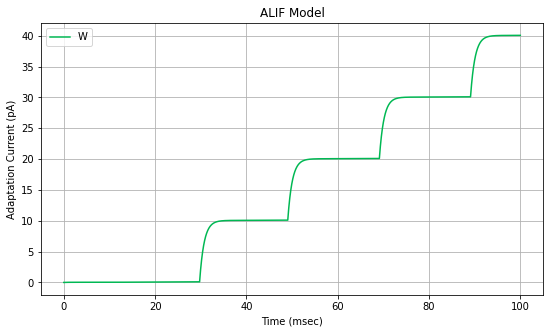

time_total = 100
dt = 0.03125
R_m = 10
Tau_m = 8
V_start = -80
V_treshold = -10.0
V_spike = 5
V_rest = -120
V_reset = -65
n_fire = 4
a = 0.001
b = 10
Tau_w = 1
W_total = 40.07295333783217


In [18]:
neuron = ALIF(V_rest=-120, V_treshold=-10., a=0.001, b=10)
I = LinearCurrent(a_1=0.5) # I(t) = 0.5 * t
I.plot_I_t(np.arange(1,100))
test(neuron, I)

#### sample 5

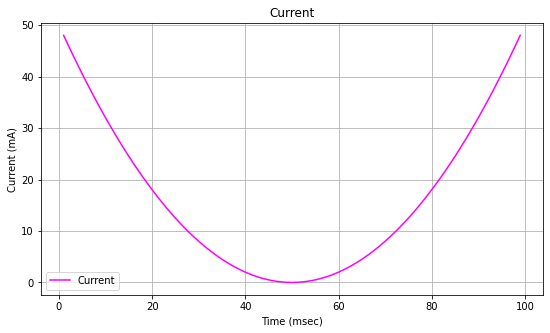

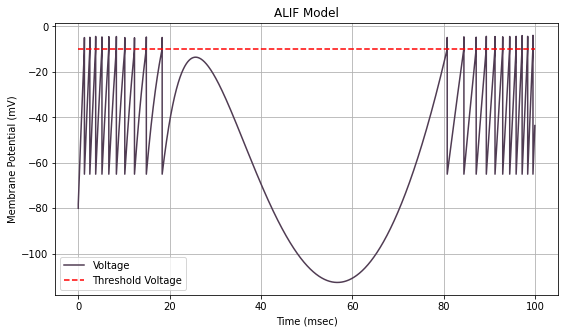

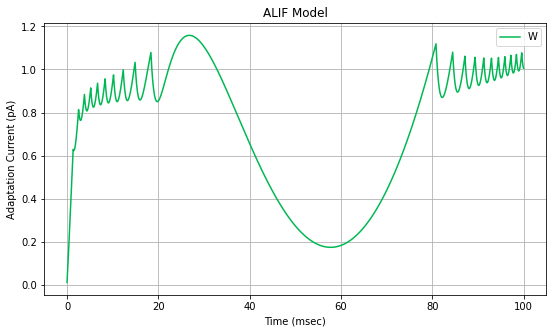

time_total = 100
dt = 0.03125
R_m = 10
Tau_m = 8
V_start = -80
V_treshold = -10
V_spike = 5
V_rest = -120
V_reset = -65
n_fire = 21
a = 0.01
b = 0.01
Tau_w = 1
W_total = 1.0058595447506649


In [19]:
neuron = ALIF(V_rest=-120, V_treshold=-10, b=0.01)
I = Current(lambda t : ((t - 50) ** 2.) / 50.) # I(t) = (t - 50) ^2
I.plot_I_t(np.arange(1,100))
test(neuron, I)

#### sample 6

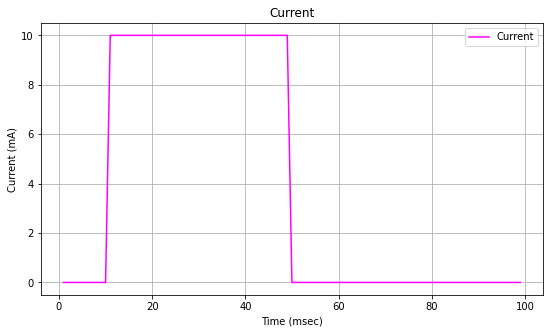

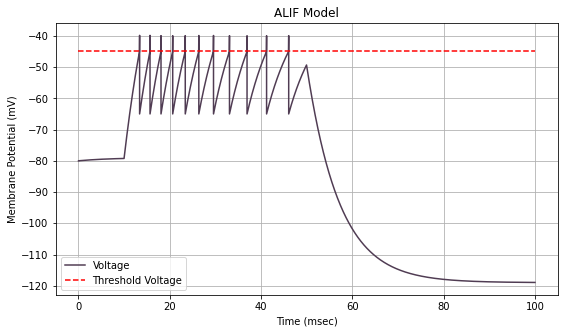

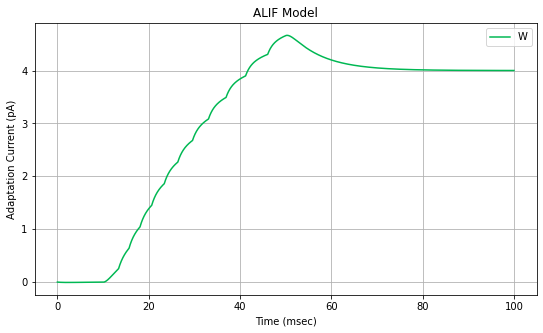

time_total = 100
dt = 0.03125
R_m = 10
Tau_m = 8
V_start = -80
V_treshold = -45
V_spike = 5
V_rest = -79
V_reset = -65
n_fire = 11
a = 0.01
b = 0.4
Tau_w = 1
W_total = 4.000745931344318


In [20]:
neuron = ALIF(b=0.4)
I = Current(lambda t : 10 if 10 < t < 50 else 0) # I = 5
I.plot_I_t(np.arange(1,100))
test(neuron, I)

#### Frequency plot

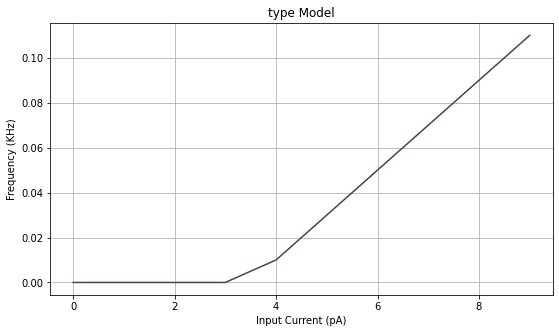

In [21]:
ALIF.frequency_current_plot()

## AELIF

### Implementation

In [22]:
class AELIF(ALIF):
    def __init__(self, time_total=100, dt=0.03125,
                R_m=10, Tau_m=8, V_start=-80,
                V_treshold=-45, V_spike=5, V_rest=-79,
                V_reset=-65, a=0.01, b=0.5, delta_T=1, theta_r_h=-55):
        super().__init__(time_total, dt, R_m, Tau_m, V_start,
                        V_treshold, V_spike, V_rest, V_reset, a, b)
        self.delta_T= delta_T
        self.theta_r_h = theta_r_h

    def calculate_exponential(self):
        return self.delta_T * exp((self.last_V - self.theta_r_h)/self.delta_T)

    def sim(self, I_t: Current):
        self.V_data = [[self.V_start, 0]] # save the voltage values
        self.n_fire = 0
        self.W_total = 0
        pass_time = 0

        while pass_time <= self.time_total:
            self.update_w()
            exponential = self.calculate_exponential()
            dv = self.calculate_dv(
                I_t.getCurrent(pass_time), exponential - (self.W_total * self.R_m) )
            self.V_data.append([self.last_V + dv, pass_time])

            self.check_threshold(pass_time)

            pass_time += self.dt

        self.last_I = I_t
        v_data = np.array(self.V_data)
        self.itr_times = v_data[:,1]
        self.V_m = v_data[:,0]

    def __str__(self)->str:
        return ( super().__str__() +
            f"\ndelta_T = {self.delta_T}"
            f"\ntheta_r_h = {self.theta_r_h}" )

### Examples AELIF Model

#### sample 1

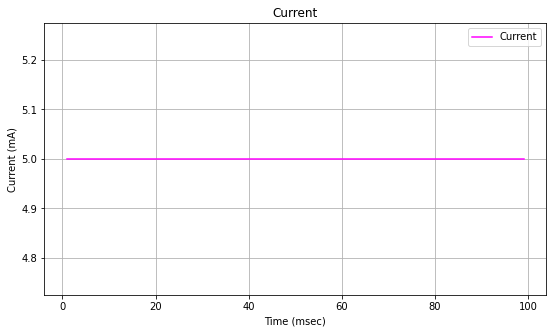

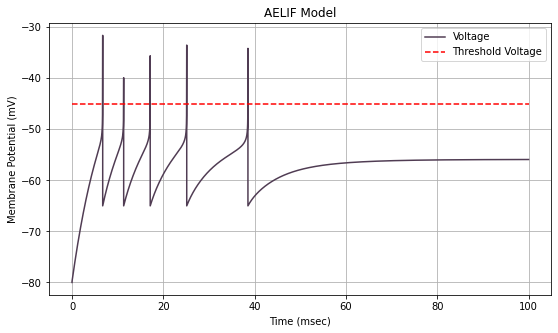

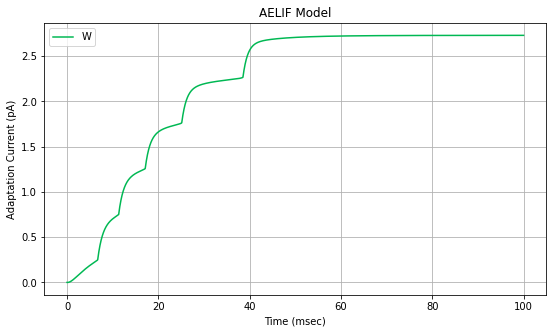

time_total = 100
dt = 0.03125
R_m = 10
Tau_m = 8
V_start = -80
V_treshold = -45
V_spike = 5
V_rest = -79
V_reset = -65
n_fire = 5
a = 0.01
b = 0.5
Tau_w = 1
W_total = 2.7307659571907292
delta_T = 1
theta_r_h = -55


In [23]:
neuron = AELIF()
I = DirectCurrent() # I = 5
I.plot_I_t(np.arange(1,100))
test(neuron, I)

#### sample 2

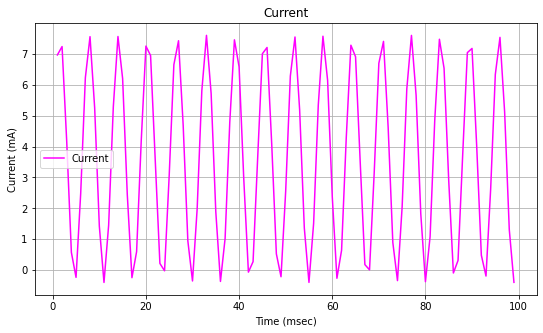

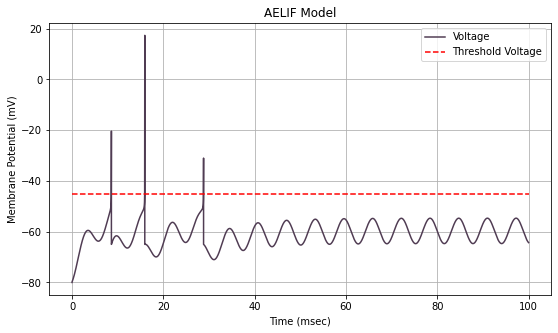

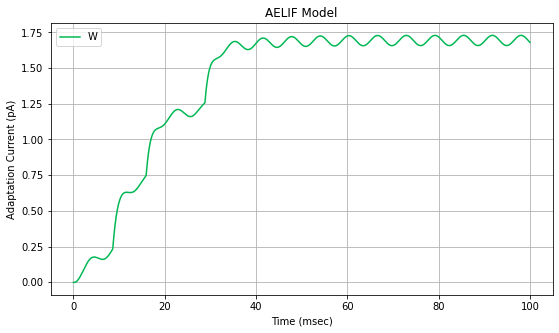

time_total = 100
dt = 0.03125
R_m = 10
Tau_m = 8
V_start = -80
V_treshold = -45
V_spike = 5
V_rest = -79
V_reset = -65
n_fire = 3
a = 0.01
b = 0.5
Tau_w = 1
W_total = 1.6798011861133049
delta_T = 1
theta_r_h = -55


In [24]:
neuron = AELIF(V_treshold=-45)
I = AlternativeCurrent(a_0=0.9, a_1=4,a_2=0) # I(t) = (0.9 + sin(t)) * 4
I.plot_I_t(np.arange(1,100))
test(neuron, I)

#### sample 3

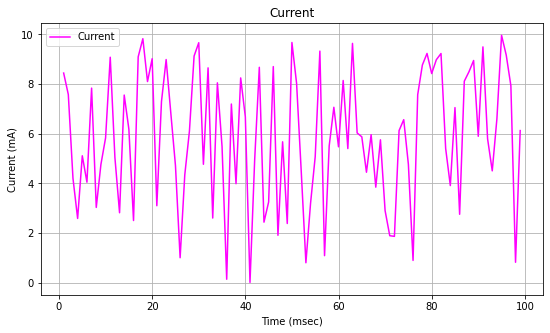

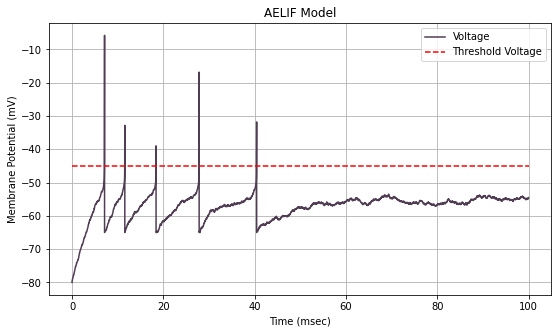

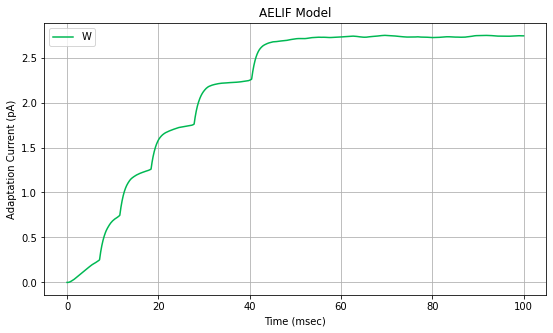

time_total = 100
dt = 0.03125
R_m = 10
Tau_m = 8
V_start = -80
V_treshold = -45
V_spike = 5
V_rest = -79
V_reset = -65
n_fire = 5
a = 0.01
b = 0.5
Tau_w = 1
W_total = 2.742490891619159
delta_T = 1
theta_r_h = -55


In [25]:
neuron = AELIF()
I = RandomCurrent(begin_range=0, end_range=10)
I.plot_I_t(np.arange(1,100))
test(neuron, I)

#### sample 4

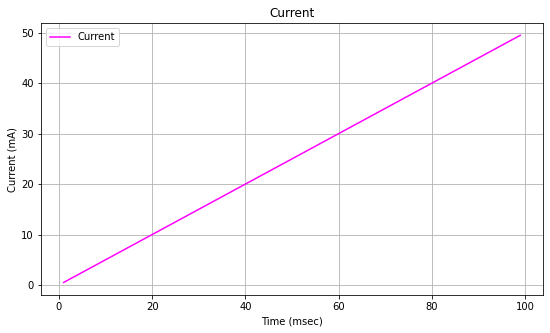

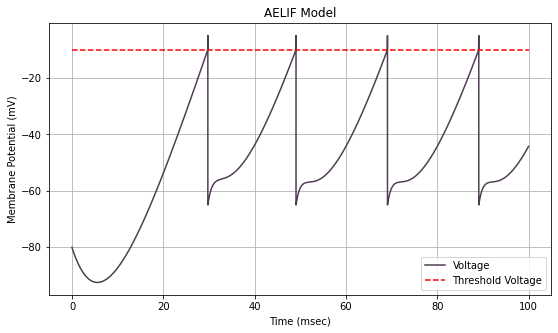

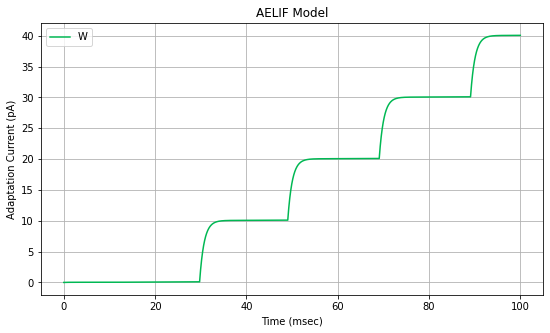

time_total = 100
dt = 0.03125
R_m = 10
Tau_m = 8
V_start = -80
V_treshold = -10.0
V_spike = 5
V_rest = -120
V_reset = -65
n_fire = 4
a = 0.001
b = 10
Tau_w = 1
W_total = 40.07295333925751
delta_T = 1
theta_r_h = -10


In [26]:
neuron = AELIF(V_rest=-120, V_treshold=-10., a=0.001, b=10, theta_r_h=-10)
I = LinearCurrent(a_1=0.5) # I(t) = 0.5 * t
I.plot_I_t(np.arange(1,100))
test(neuron, I)

#### sample 5

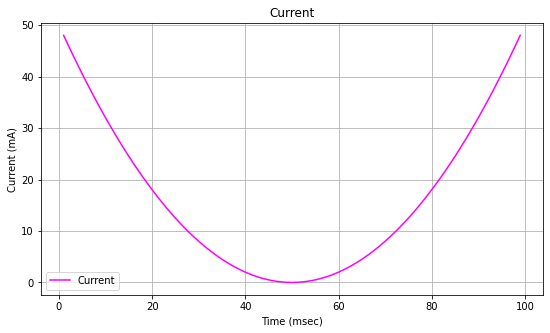

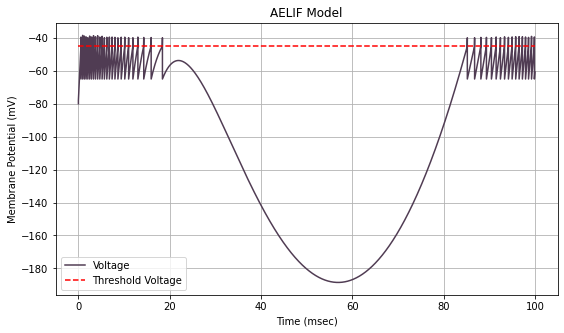

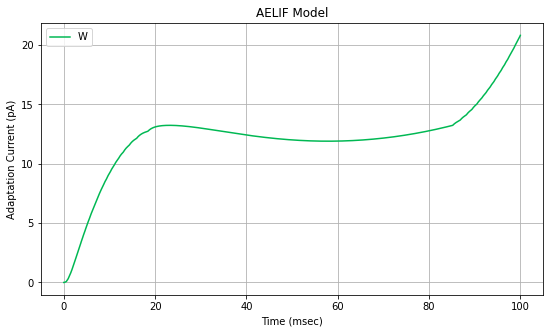

time_total = 100
dt = 0.03125
R_m = 10
Tau_m = 8
V_start = -80
V_treshold = -45
V_spike = 5
V_rest = -79
V_reset = -65
n_fire = 43
a = 0.01
b = 0.5
Tau_w = 1
W_total = 20.8262646897717
delta_T = 1
theta_r_h = -10


In [27]:
neuron = AELIF(theta_r_h=-10)
I = Current(lambda t : ((t - 50) ** 2.) / 50.) # I(t) = (t - 50) ^2
I.plot_I_t(np.arange(1,100))
test(neuron, I)

#### sample 6

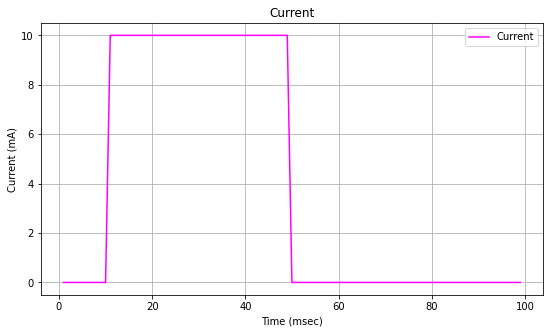

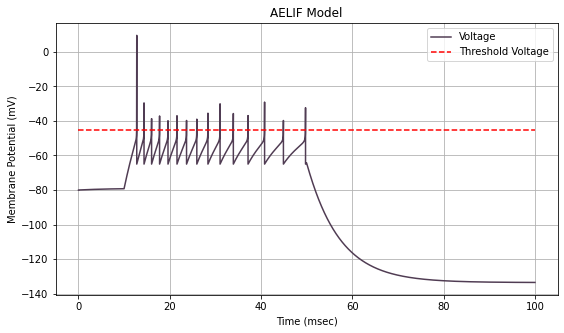

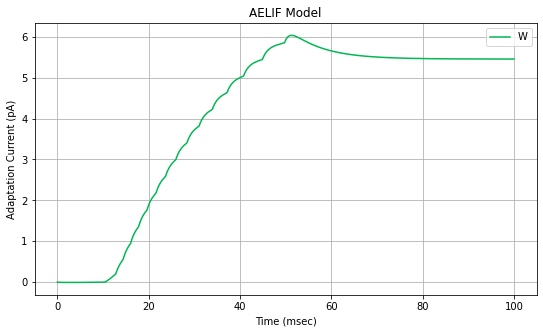

time_total = 100
dt = 0.03125
R_m = 10
Tau_m = 8
V_start = -80
V_treshold = -45
V_spike = 5
V_rest = -79
V_reset = -65
n_fire = 15
a = 0.01
b = 0.4
Tau_w = 1
W_total = 5.455290240389308
delta_T = 1
theta_r_h = -55


In [28]:
neuron = AELIF(b=0.4)
I = Current(lambda t : 10 if 10 < t < 50 else 0) # I = 5
I.plot_I_t(np.arange(1,100))
test(neuron, I)

#### Frequency plot

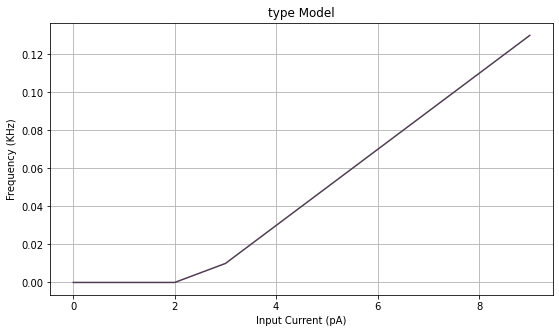

In [29]:
AELIF.frequency_current_plot()